In [ ]:
''' 
filter 1: IC
算出來的pct_change => resample("W") => ARIMA_factor

calculate Information Correlation with pct_change().resample("W") => conclude that information correlation is stationary

用因子有效度決定持倉/空倉

## 問題： 分成 "因子有效的時候的pvalue" vs. "因子無效時的pvalue" 確認 pvalue 會不會有問題

filter 2: quantile test
把所有factor切成10個百分位, 畫出報酬圖, 得出 '因子有沒有顯著差異' => '這個因子到底該不該用'

## 問題： arima(factor是預期下一期pct_change的數字) 好像沒辦法很輕易切10個百分位後還有意義
filter 3: IR test



final filter:
在生出所有因子, 加上每個因子都有個別檢驗上面的東東後, 用barra risk model 檢查多因子策略本身的風險.

'''

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from datetime import datetime, timedelta
factor = pd.read_csv("../factor/data/ARIMA_freqW_factors_20d_bestlag_first100.csv", index_col=0) # since 2010
close = pd.read_parquet("../db/tw/Adj_close.parquet")
close = close.loc[factor.index[0]:]
factor.columns = close.columns[:100] # 不然電腦跑不完

In [8]:
factor = pd.read_csv("../factor/data/ARIMA_freqW_factors_20d_bestlag_first100.csv", index_col=0) # since 2010
factor.columns = close.columns[:100]


In [9]:
pct_change = close.pct_change(fill_method=None).shift(-1)[:-1]
pct_change_w = pct_change.resample("W").sum()
pct_change_w = pct_change_w.shift(-1)
pct_change_w.index = pd.to_datetime(pct_change_w.index)
factor.index = pd.to_datetime(factor.index)

# fit stock list
pct_change_w_filtered = pct_change_w[list(factor.columns)]


In [10]:
ics = pd.Series([0] * len(pct_change_w_filtered), index=pct_change_w_filtered.index)
pvalues = pd.Series([0] * len(pct_change_w_filtered), index=pct_change_w_filtered.index)
for index, i in enumerate(list(pct_change_w_filtered.index)):
    ic = st.spearmanr(factor.loc[i].fillna(0), pct_change_w_filtered.loc[i].fillna(0))
    ics[index] = ic[0]
    pvalues[index] = ic[1]

/var/folders/zc/_sy5126x4ks5w74_nsrx_mv40000gp/T/ipykernel_22281/648080521.py:5: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ics[index] = ic[0]
/var/folders/zc/_sy5126x4ks5w74_nsrx_mv40000gp/T/ipykernel_22281/648080521.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08248512888301389' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ics[index] = ic[0]
/var/folders/zc/_sy5126x4ks5w74_nsrx_mv40000gp/T/ipykernel_22281/648080521.py:6: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  pv

IC: stationary


('IR:', 0.7909657490901738)

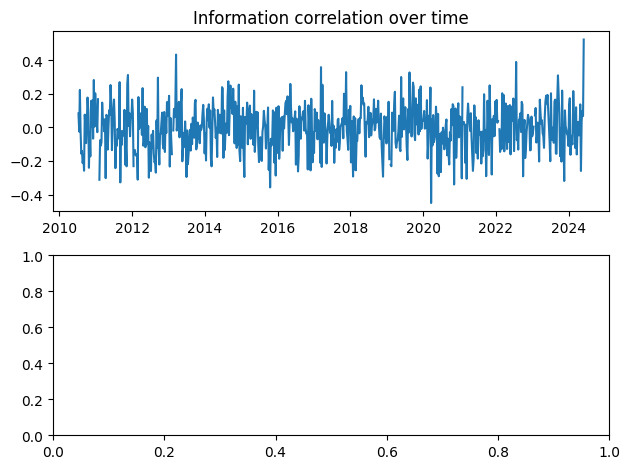

In [58]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
ics_dropna = [i for i in list(ics) if i > 0 or i < 0]
ics_ma = ics.rolling(20).mean()
res = adfuller(ics_dropna)
fig, ax = plt.subplots(2, 1)
ax[0].plot(ics)
ax[0].set_title("Information correlation over time")
# ax[1].plot(pvalues)
# ax[1].set_title("Pvalue")
if res[1] < 0.05 and res[0] < res[4]['5%']:
    print("IC: stationary")
# t-test , p-value, {}: corresponding t-test critical value, res[0] needs to be smaller than value inside {}
fig.tight_layout()
# pvalue over enlarged, not sufficient
IR = np.mean(np.abs(ics))/np.std(ics)
"IR:", IR

Text(0.5, 1.0, 'return')

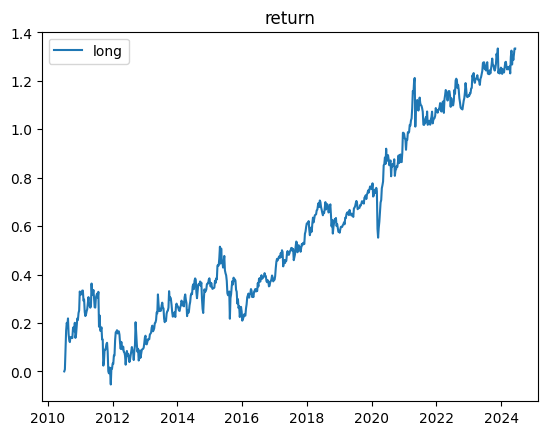

In [12]:
# test 2: quantile test
def factor_to_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = factor.sub(factor.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting * 2

# demean factor
weighting = factor_to_weighting(factor)
weighting_long = weighting[weighting > 0].fillna(0)
weighting_short = weighting[weighting < 0].fillna(0)

# pct_return_short = (weighting_short * pct_change_w_filtered).sum(axis=1)
# cumsum_short = pct_return_short.cumsum()
# plt.plot(cumsum_short, label='short')
# pct_return_ls = (weighting * pct_change_w_filtered).sum(axis=1)
# cumsum_ls = pct_return_ls.cumsum()
# plt.plot(cumsum_ls, label='ls')

pct_return_long = (weighting_long * pct_change_w_filtered).sum(axis=1)
cumsum_long = pct_return_long.cumsum()

plt.plot(cumsum_long, label='long')
plt.legend()
plt.title("return")
# stock pool: 0050 - 13xx 全是低波動股票

Maximum Drawdown (MDD): -28.90%


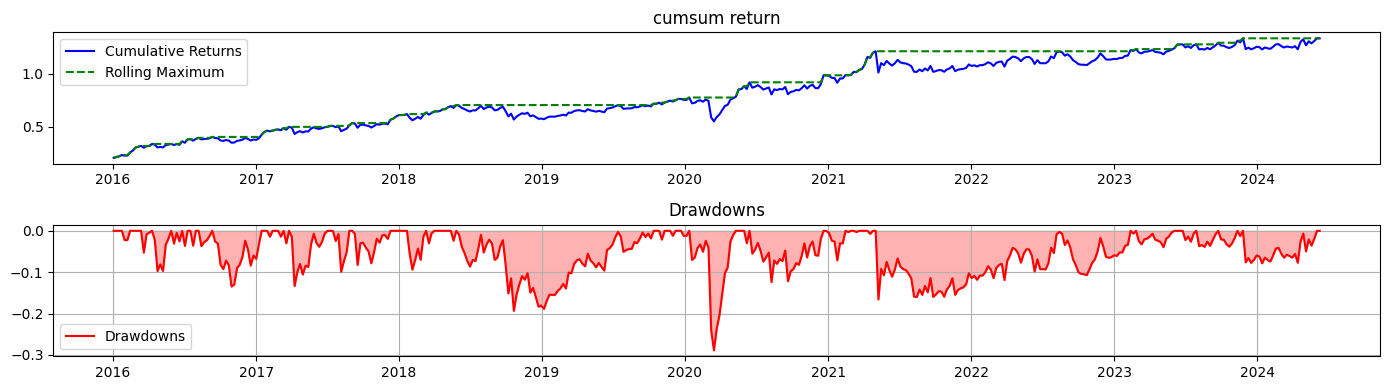

In [13]:
cumulative_returns = cumsum_long.loc[pd.to_datetime('2016-01-01'):]

rolling_max = cumulative_returns.cummax()

drawdowns = (cumulative_returns - rolling_max) / rolling_max

max_drawdown = drawdowns.min()

# Print the Maximum Drawdown
print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))

plt.figure(figsize=(14, 4))

plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.plot(rolling_max, label='Rolling Maximum', color='green', linestyle='--')
plt.title("cumsum return")
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdowns, label='Drawdowns', color='red')
plt.fill_between(drawdowns.index, drawdowns, color='red', alpha=0.3)
plt.title('Drawdowns')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
portfolio_returns = pct_return_long
fee= 0 
returns_series = cumsum_long
def sharpe_ratio(returns, risk_free_rate=0.03):
    excess_return = ((1 + returns).cumprod()*(1-fee)) - risk_free_rate
    return  (np.mean(excess_return)/ np.std(excess_return))**(1/4)
def karma_ratio(returns):
    positive_returns = returns[returns > 0]
    negative_returns = returns[returns < 0]

    if len(negative_returns) == 0:
        karma_ratio = np.mean(positive_returns) / 0.00001  # Avoid division by zero
    else:
        karma_ratio = np.mean(positive_returns) / np.abs(np.mean(negative_returns))

    return karma_ratio

print("Sharpe Ratio:", sharpe_ratio(portfolio_returns))
print(f"CAGR: {np.round(((returns_series.iloc[-1])**(1/4)-1)*100, 2)}%")
print("Karma Ratio:", karma_ratio(portfolio_returns))

Sharpe Ratio: 1.3151841602852294
CAGR: 7.46%
Karma Ratio: 0.8933409716713839


Text(0.5, 1.0, 'quantile 4 factor performance')

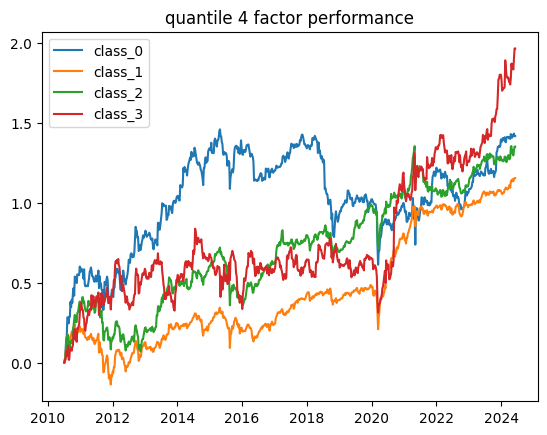

In [51]:
# quantile
factor_mean = factor.mean(axis=1)
factor_std = factor.std(axis=1)
factor_critical_value = [factor_mean + (-2+i)*factor_std for i in range(5)]

df_factor_cv_0 = pd.concat([factor_critical_value[0]]*len(factor.columns), axis=1)
df_factor_cv_1 = pd.concat([factor_critical_value[1]]*len(factor.columns), axis=1)
df_factor_cv_2 = pd.concat([factor_critical_value[2]]*len(factor.columns), axis=1)
df_factor_cv_3 = pd.concat([factor_critical_value[3]]*len(factor.columns), axis=1)
df_factor_cv_4 = pd.concat([factor_critical_value[4]]*len(factor.columns), axis=1)
df_factor_cv_0.columns = factor.columns
df_factor_cv_1.columns = factor.columns
df_factor_cv_2.columns = factor.columns
df_factor_cv_3.columns = factor.columns
df_factor_cv_4.columns = factor.columns

factor_class_0 = factor[(factor > df_factor_cv_0) & (factor < df_factor_cv_1)]
factor_class_1 = factor[(factor > df_factor_cv_1) & (factor < df_factor_cv_2)]
factor_class_2 = factor[(factor > df_factor_cv_2) & (factor < df_factor_cv_3)]
factor_class_3 = factor[(factor > df_factor_cv_3) & (factor < df_factor_cv_4)]

def get_cumsum_from_factor(factor):
    weighting = factor_to_weighting(factor)
    weighting_long = weighting[weighting > 0].fillna(0)
    pct_return_long = (weighting_long * pct_change_w_filtered).sum(axis=1)
    cumsum_long = pct_return_long.cumsum()
    return cumsum_long

cumsum_factor_class_0 = get_cumsum_from_factor(factor_class_0)
cumsum_factor_class_1 = get_cumsum_from_factor(factor_class_1)
cumsum_factor_class_2 = get_cumsum_from_factor(factor_class_2)
cumsum_factor_class_3 = get_cumsum_from_factor(factor_class_3)
plt.plot(cumsum_factor_class_0, label='class_0')
plt.plot(cumsum_factor_class_1, label='class_1')
plt.plot(cumsum_factor_class_2, label='class_2')
plt.plot(cumsum_factor_class_3, label='class_3')
plt.legend()
plt.title("quantile 4 factor performance")

In [ ]:
# 不明顯